# DATA2 -  RF - baseline - FAQ
## Features:
1. 'AGE'
1. 'RAVLT\_immediate'
1. 'AVDEL30MIN\_neuro'
1. 'AVDELTOT\_neuro'
1. 'TRAASCOR\_neuro'
1. 'TRABSCOR\_neuro'
1. 'CATANIMSC\_neuro'
1. 'GDTOTAL\_gds'
1. 'LRHHC\_n\_long'
1. 'LRLV\_n\_long'
1. 'FAQ'
1. 'Gender\_num\_'
1. 'PTGENDER'
1. 'Subgroup\_'
1. 'Subgroup\_num\_'
1. 'Usage\_'

---

**Resources**
1. DATA
    1. [data/data2](https://github.com/MMIV-ML/MCI-subgroups/tree/master/data/data2) - csv files downloaded from ADNI,
    1. [data/data2_FS](https://github.com/MMIV-ML/MCI-subgroups/tree/master/data/data2_FS) - FS result csv files,
    1. [data_zip/20201109_data2_file_versions](https://github.com/MMIV-ML/MCI-subgroups/blob/master/data/data_zip/20201109_data2_file_versions.pdf) - download ADNI web page screen shoot taken for downaloaded csv files (some of file neames are printed with dates),
1. RESULTS
    1. [results/20210420](https://github.com/MMIV-ML/MCI-subgroups/tree/master/results/20210420) - result folder,
    1. [results/202100420/README.md](https://github.com/MMIV-ML/MCI-subgroups/blob/master/results/20210420/README.md) - short description,
1. GOOGLE DRIVE
    1. [slides](https://docs.google.com/presentation/d/1aEK7M5BPe0RxWYskzQCEDbT4Mf-4mRRqQ5uJ_YuqRzg/edit#slide=id.p) - link to google slides (**OUT OF DATE, MUST BE UPDATED !!!**),
    1. [GoogleDrive](https://drive.google.com/drive/folders/1r8l2R88-0T8Xahk30iAgjBCWXvV1R2J-) - the main google drive slide folder,
1. GIT HUB
    1. [GitHub](https://github.com/MMIV-ML/MCI-subgroups) - the main repo folder,
1. [An overview](https://github.com/MMIV-ML/MCI-subgroups/blob/master/results/20210420/3.xx_RF_bl_comparison.pdf)


The latest changes (ver. 0.15):

    - feature perumtation function from scratch - moved to 3.02-data2-RF-bl-permutation.ipynb,
    - Conf_mat_ results (TP, TN, FP, FN),
    - Replace manual CV scores with built-in functions,
    - CV folds split loaded from file (to use in `bl` and `long`)... TO DO 
    
   *Created: 2021.03.18 / Updated: 2021.07.21*
   
---

#### IMPORTS

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import eli5
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from pdpbox import pdp
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import display, SVG, Image
from eli5.sklearn import PermutationImportance

In [3]:
import mci_info as minfo
import mci_utils as mutils
import mci_freesurfer as mfs
import mci_rf_bl as mrfbl

In [4]:
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.inspection import plot_partial_dependence

#### GLOBAL PATH VARIABLES

In [5]:
# Notebook folder
NB_DIR = %pwd
NB_DIR = Path(NB_DIR)
# Root MCI foler
ROOT_DIR = NB_DIR.parent
# Main data folder (with downloaded csv files)
MAIN_DATA_DIR = ROOT_DIR/'data/data2'
DATA_DIR_FS = ROOT_DIR / 'data/data2_FS'
# Current data dir with sMCI_cAD.csv & bl.csv files
CURRENT_DATA_DIR = ROOT_DIR/'results/20201110'
# Results folder
RESULTS_DIR = ROOT_DIR/'results/20210420' #misclassified patient table
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

#### INSTALLED PACKAGES INFO

In [6]:
if 1:
    packages = ['numpy', 'scipy', 'seaborn', 'pandas', 'matplotlib', 'statsmodels',
                'ipywidgets', 'eli5', 'pdpbox', 'sklearn']
    display(mutils.package_versions(installedOnly=False, theMostImportant=packages))



Computer name: mk-prec-7540
Operating system: Linux, 64bit

Python path: /home/marek/miniconda3/envs/py37/bin/python
Python version: 3.7.7 (default, Mar 26 2020, 15:48:22) 
[GCC 7.3.0]



module version
4          eli5  0.11.0
6    ipywidgets   7.6.2
10   matplotlib   3.3.4
12        numpy  1.19.2
14       pandas   1.1.5
15       pdpbox   0.2.1
19        scipy   1.5.2
20      seaborn  0.11.1
22      sklearn  0.24.1
23  statsmodels  0.11.1

---

##  FEATURES TO FEED A MODEL - THESE GLOBAL VARIABLES MUST BE UPDATED IN EACH NOTEBOOK SEPARATELY!!! 

In [7]:
FEATURES = ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro',
            'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro',
            'GDTOTAL_gds', 'LRHHC_n_long','LRLV_n_long', 'FAQ',
            'Subgroup_', 'Subgroup_num_', 'Usage_',
           'Gender_num_', 'PTGENDER'
           ]


# Filename prefixes used to save all results (tables, images, ...)
FILE_NAME_PREFIX = '3.32_RF-bl'
FILE_NAME_NUMBER = FILE_NAME_PREFIX.split('_')[0]

# To use GS model from different file
FILE_NAME_WITH_GS_MODEL_TO_LOAD = FILE_NAME_PREFIX


# random state
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# folds 
FOLDS = 10

# display all stuff
VERBOSE = True

---

## LOAD BASELINE FILE AND RESTRICT COLUMN RANGE TO SELECTED FEATURES ONLY (FEATURES + Subgroup\_ x2 + Usage\_)

In [8]:
bl_name = CURRENT_DATA_DIR / 'bl.csv'
bl_loaded = pd.read_csv(bl_name, index_col=0)

bl_sel_feat = bl_loaded[FEATURES]

print(f'Subjects: \t{bl_sel_feat.shape[0]}')
print(f'Columns: \t{bl_sel_feat.shape[1]}')

Subjects: 	708
Columns: 	16


#### DISPLAY THE NAN VALUES IN THE WHOLE DATA FRAME

In [9]:
if VERBOSE:
    print(bl_sel_feat.isnull().sum())
    bl_sel_feat.shape

AGE                  0
RAVLT_immediate      0
AVDEL30MIN_neuro     0
AVDELTOT_neuro       1
TRAASCOR_neuro       0
TRABSCOR_neuro      10
CATANIMSC_neuro      0
GDTOTAL_gds          0
LRHHC_n_long        14
LRLV_n_long         14
FAQ                  4
Subgroup_            0
Subgroup_num_        0
Usage_               0
Gender_num_          0
PTGENDER             0
dtype: int64


### SPLIT BETWEEN TRAIN AND TEST SUBSETS

In [10]:
bl_train = bl_sel_feat.loc[bl_sel_feat.Usage_ == 'train']
bl_test = bl_sel_feat.loc[bl_sel_feat.Usage_ == 'test']

# a list of both sets, to ease forfurther manipulation
bl_sets = [['Train set', bl_train], ['Test set', bl_test]]

---

## TRAIN / TEST SETS SHORT INFO

In [11]:
if VERBOSE: 
    print('Subjects in:')
    for name, bl in bl_sets:
        print(f'\t{name}:\t{bl.shape[0]} ({bl.shape[0]/bl_sel_feat.shape[0] * 100:.0f}%)')

    print('\n\nSubjects in each subgroup (with NaN included):\n')
    for name, bl in bl_sets:
        print(f'*** {name} ***\n{bl.Subgroup_.value_counts().to_string()}\n')

Subjects in:
	Train set:	566 (80%)
	Test set:	142 (20%)


Subjects in each subgroup (with NaN included):

*** Train set ***
sMCI    305
cAD     261

*** Test set ***
sMCI    76
cAD     66



#### PRINT COLUMN NAMES INCLUDED IN BOTH SETS

In [12]:
minfo.included_feature_info(bl_train, pattern='adni-neuro-long-_')

Total number of columns: 16



adni (#4)        neuro (#5)     long (#2)      ours (#4)
0              AGE  AVDEL30MIN_neuro  LRHHC_n_long    Gender_num_
1              FAQ    AVDELTOT_neuro   LRLV_n_long      Subgroup_
2         PTGENDER   CATANIMSC_neuro                Subgroup_num_
3  RAVLT_immediate    TRAASCOR_neuro                       Usage_
4                     TRABSCOR_neuro

---

## COUNT `NaN` VALUES IN TRAIN AND TEST SETS

In [13]:
if VERBOSE:
    for name, bl in bl_sets:        
        print(f'*** NaN values in {name.upper()} set (out of {bl.shape[0]} rows) ***')
        print(bl.isnull().sum().to_string())
        print(f'\nRows in {name}: {bl.shape[0]}')
        print('\n\n')

*** NaN values in TRAIN SET set (out of 566 rows) ***
AGE                  0
RAVLT_immediate      0
AVDEL30MIN_neuro     0
AVDELTOT_neuro       1
TRAASCOR_neuro       0
TRABSCOR_neuro      10
CATANIMSC_neuro      0
GDTOTAL_gds          0
LRHHC_n_long        13
LRLV_n_long         13
FAQ                  3
Subgroup_            0
Subgroup_num_        0
Usage_               0
Gender_num_          0
PTGENDER             0

Rows in Train set: 566



*** NaN values in TEST SET set (out of 142 rows) ***
AGE                 0
RAVLT_immediate     0
AVDEL30MIN_neuro    0
AVDELTOT_neuro      0
TRAASCOR_neuro      0
TRABSCOR_neuro      0
CATANIMSC_neuro     0
GDTOTAL_gds         0
LRHHC_n_long        1
LRLV_n_long         1
FAQ                 1
Subgroup_           0
Subgroup_num_       0
Usage_              0
Gender_num_         0
PTGENDER            0

Rows in Test set: 142





#### DISPLAY ALL SUBJECTS THAT CONTAIN `NaN` VALUES (BOTH SETS)

In [14]:
if VERBOSE:
    for name, bl in bl_sets:
        num = bl.isnull().sum().sum()
        #idx = bl.isnull().index
        print(f'*** {name.upper()} ***')
        display(bl.loc[bl.isnull().any(axis=1)].head(num))
        print()

*** TRAIN SET ***


AGE  RAVLT_immediate  AVDEL30MIN_neuro  AVDELTOT_neuro  TRAASCOR_neuro  \
20    83.3             21.0               0.0             7.0            34.0   
130   70.3             22.0               2.0            13.0            60.0   
1883  69.1             32.0               0.0            11.0            60.0   
2284  69.0             29.0               1.0            11.0            54.0   
2948  61.7             21.0               0.0             6.0            57.0   
3437  75.2             27.0               3.0            10.0            22.0   
3523  81.6             28.0               3.0            10.0            61.0   
3547  76.6             33.0               8.0            14.0            40.0   
3639  66.7             55.0              11.0            14.0            33.0   
3652  71.0             20.0               0.0             8.0            60.0   
3883  56.3             53.0               9.0            15.0            30.0   
4133  68.9             47.0               8.0            11.0            23.0   
4153  86.4             17.0               2.0             7.0            72.0   
4484  69.4             38.0               5.0             9.0            49.0   
4713  71.9             42.0               4.0            15.0            28.0   
4814  76.8             39.0               7.0            14.0            30.0   
4913  71.3             44.0               0.0             NaN            28.0   
4930  68.1             54.0              13.0            15.0            27.0   
5077  77.6             26.0               3.0             7.0            53.0   
5353  79.3             25.0               0.0             3.0            38.0   
5462  68.5             47.0              11.0            14.0            46.0   
5530  65.4             34.0               2.0            15.0            41.0   
5831  71.9             28.0               5.0            11.0            36.0   
5855  85.3             24.0               3.0             8.0            72.0   
5978  55.0             42.0               7.0            13.0            23.0   
6140  69.0             29.0               0.0             4.0            27.0   

      TRABSCOR_neuro  CATANIMSC_neuro  GDTOTAL_gds  LRHHC_n_long  LRLV_n_long  \
20               NaN             16.0          2.0      0.003313     0.018348   
130            170.0              5.0          2.0      0.004205     0.040182   
1883            93.0             12.0          1.0      0.003544     0.011873   
2284             NaN             11.0          5.0      0.004512     0.021344   
2948             NaN             10.0          2.0      0.005170     0.006507   
3437           112.0             22.0          0.0           NaN          NaN   
3523           170.0             14.0          0.0           NaN          NaN   
3547             NaN             13.0          3.0           NaN          NaN   
3639             NaN             28.0          3.0      0.005139     0.011287   
3652           176.0             20.0          1.0           NaN          NaN   
3883             NaN             24.0          4.0      0.005942     0.009620   
4133            50.0             17.0          2.0           NaN          NaN   
4153           300.0              5.0          5.0           NaN          NaN   
4484             NaN             18.0          1.0      0.004482     0.020382   
4713            91.0             20.0          1.0           NaN          NaN   
4814             NaN             22.0          3.0      0.004488     0.036043   
4913            45.0             20.0          1.0      0.003201     0.028816   
4930            65.0             17.0          0.0           NaN          NaN   
5077           180.0             23.0          5.0           NaN          NaN   
5353           120.0             17.0          4.0           NaN          NaN   
5462           119.0             16.0          2.0      0.005090     0.016064   
5530            67.0             11.0


*** TEST SET ***


AGE  RAVLT_immediate  AVDEL30MIN_neuro  AVDELTOT_neuro  TRAASCOR_neuro  \
2119  55.1             31.0               2.0             8.0            23.0   
3926  63.0             32.0               5.0            15.0            35.0   

      TRABSCOR_neuro  CATANIMSC_neuro  GDTOTAL_gds  LRHHC_n_long  LRLV_n_long  \
2119            72.0             16.0          1.0      0.005315     0.010229   
3926           105.0             21.0          2.0           NaN          NaN   

      FAQ Subgroup_  Subgroup_num_ Usage_  Gender_num_ PTGENDER  
2119  NaN       cAD              1   test            1   Female  
3926  3.0      sMCI              0   test            0     Male

In [15]:
if VERBOSE:
    display(Image(filename="figs/assets/NaN_subjects.png", width=900))

## DROP `NaN` VALUES IN TRAIN AND TEST SETS (IF ANY)

In [16]:
print('\nSubjects number in both sets AFTER dropping NaN values:\n')
for name, bl in bl_sets:
    bl.dropna(axis='rows', inplace=True)
    print(f' - {name}: {bl.shape[0]}')


Subjects number in both sets AFTER dropping NaN values:

 - Train set: 540
 - Test set: 140


#### COUNT `NaN` VALUES IN TRAIN AND TEST SETS (AFTER DROP `NaN` ROWS) 

In [17]:
if VERBOSE:
    for name, bl in bl_sets:        
        print(f'*** NaN values in {name.upper()} set (out of {bl.shape[0]} rows) ***')
        print(bl.isnull().sum().to_string())
        print(f'\nRows in {name}: {bl.shape[0]}')
        print('\n\n')

*** NaN values in TRAIN SET set (out of 540 rows) ***
AGE                 0
RAVLT_immediate     0
AVDEL30MIN_neuro    0
AVDELTOT_neuro      0
TRAASCOR_neuro      0
TRABSCOR_neuro      0
CATANIMSC_neuro     0
GDTOTAL_gds         0
LRHHC_n_long        0
LRLV_n_long         0
FAQ                 0
Subgroup_           0
Subgroup_num_       0
Usage_              0
Gender_num_         0
PTGENDER            0

Rows in Train set: 540



*** NaN values in TEST SET set (out of 140 rows) ***
AGE                 0
RAVLT_immediate     0
AVDEL30MIN_neuro    0
AVDELTOT_neuro      0
TRAASCOR_neuro      0
TRABSCOR_neuro      0
CATANIMSC_neuro     0
GDTOTAL_gds         0
LRHHC_n_long        0
LRLV_n_long         0
FAQ                 0
Subgroup_           0
Subgroup_num_       0
Usage_              0
Gender_num_         0
PTGENDER            0

Rows in Test set: 140





### COUNT TRAIN / TEST  PERCENTAGE PROPORTION AFTER EXCLUDING NaN VALUES

In [18]:
print('Subjects in:')
for name, bl in bl_sets:
    print(f'\t{name}:\t{bl.shape[0]} ({bl.shape[0]/(bl_train.shape[0] + bl_test.shape[0]) * 100:.0f}%)')

print('\n\nSubjects in each subgroup (without NaN):\n')
for name, bl in bl_sets:
    #print(f'*** {name} ***\n')
    mutils.textWrap(name)
    print()
    #print(f'{bl.Subgroup_.value_counts().to_string()}\n')
    #print(f'{bl.PTGENDER.value_counts().to_string()}\n')
    
    dfs = bl.Subgroup_.value_counts().rename_axis('Subgroup_').reset_index(name='#Nr')
    dfp = bl.PTGENDER.value_counts().rename_axis('PTGENDER').reset_index(name='#Nr')
    df = pd.concat([dfs,dfp],axis=1)
    display(df)
    

    cols1 = ['AGE']
    cols2 = ['PTGENDER'] 
    df1 = bl.groupby(['Subgroup_', 'PTGENDER'])
    a = df1[cols1].mean().round(2)
    c = df1[cols1].std().round(2)
    b = df1[cols2].count()
    
    df_abc = pd.concat([a,c,b],axis=1) 
    display(df_abc)

Subjects in:
	Train set:	540 (79%)
	Test set:	140 (21%)


Subjects in each subgroup (without NaN):


#################
### Train set ###
#################



Subgroup_  #Nr PTGENDER  #Nr
0      sMCI  285     Male  327
1       cAD  255   Female  213

AGE   AGE  PTGENDER
Subgroup_ PTGENDER                       
cAD       Female    72.53  7.35        99
          Male      74.87  6.57       156
sMCI      Female    72.38  7.45       114
          Male      73.74  7.49       171


################
### Test set ###
################



Subgroup_  #Nr PTGENDER  #Nr
0      sMCI   75     Male   83
1       cAD   65   Female   57

AGE   AGE  PTGENDER
Subgroup_ PTGENDER                       
cAD       Female    73.51  8.26        25
          Male      74.73  6.87        40
sMCI      Female    71.62  7.96        32
          Male      73.76  6.70        43

### SOME `SUBGROUP\_` STATISTICS

In [19]:
if VERBOSE:
    print('Basic statistics for features in both sets:')
    for name, bl in bl_sets:
        mutils.textWrap(name)
        print(f'\nSubjects {bl.shape[0]}')
        
        for gr in ['sMCI', 'cAD']:
            print(f'\n*** {gr} ***')
            display(minfo.df_stats_info(bl[bl.Subgroup_ == gr]))

Basic statistics for features in both sets:

#################
### Train set ###
#################

Subjects 540

*** sMCI ***


max.     mean    min.     std  val_range  NaN_Nr
AGE                91.400   73.198  55.900   7.489     35.500       0
RAVLT_immediate    67.000   36.902  13.000  10.828     54.000       0
AVDEL30MIN_neuro   15.000    4.968   0.000   3.980     15.000       0
AVDELTOT_neuro     15.000   11.235   0.000   3.175     15.000       0
TRAASCOR_neuro    148.000   39.421  13.000  16.358    135.000       0
TRABSCOR_neuro    300.000  109.856  33.000  60.193    267.000       0
CATANIMSC_neuro    32.000   17.740   6.000   5.167     26.000       0
GDTOTAL_gds         6.000    1.677   0.000   1.471      6.000       0
LRHHC_n_long        0.006    0.005   0.003   0.001      0.004       0
LRLV_n_long         0.076    0.026   0.005   0.013      0.071       0
FAQ                15.000    1.937   0.000   2.960     15.000       0
Subgroup_num_       0.000    0.000   0.000   0.000      0.000       0
Gender_num_         1.000    0.400   0.000   0.491      1.000       0


*** cAD ***


max.     mean    min.     std  val_range  NaN_Nr
AGE                88.300   73.961  55.200   6.964     33.100       0
RAVLT_immediate    67.000   28.831  11.000   7.846     56.000       0
AVDEL30MIN_neuro   15.000    1.922   0.000   2.613     15.000       0
AVDELTOT_neuro     15.000    9.314   0.000   3.552     15.000       0
TRAASCOR_neuro    150.000   44.867  17.000  19.999    133.000       0
TRABSCOR_neuro    300.000  134.184  40.000  72.247    260.000       0
CATANIMSC_neuro    35.000   15.851   5.000   4.885     30.000       0
GDTOTAL_gds         6.000    1.702   0.000   1.430      6.000       0
LRHHC_n_long        0.006    0.004   0.002   0.001      0.004       0
LRLV_n_long         0.065    0.027   0.006   0.012      0.059       0
FAQ                22.000    4.945   0.000   4.531     22.000       0
Subgroup_num_       1.000    1.000   1.000   0.000      0.000       0
Gender_num_         1.000    0.388   0.000   0.488      1.000       0


################
### Test set ###
################

Subjects 140

*** sMCI ***


max.     mean    min.     std  val_range  NaN_Nr
AGE                87.800   72.843  57.800   7.292     30.000       0
RAVLT_immediate    65.000   36.800  20.000   9.167     45.000       0
AVDEL30MIN_neuro   14.000    4.653   0.000   3.656     14.000       0
AVDELTOT_neuro     15.000   11.427   1.000   3.098     14.000       0
TRAASCOR_neuro     87.000   38.307  16.000  12.055     71.000       0
TRABSCOR_neuro    283.000  102.227  54.000  44.570    229.000       0
CATANIMSC_neuro    30.000   18.147   6.000   4.977     24.000       0
GDTOTAL_gds         5.000    1.813   0.000   1.281      5.000       0
LRHHC_n_long        0.007    0.004   0.003   0.001      0.004       0
LRLV_n_long         0.060    0.025   0.010   0.012      0.050       0
FAQ                21.000    2.373   0.000   4.056     21.000       0
Subgroup_num_       0.000    0.000   0.000   0.000      0.000       0
Gender_num_         1.000    0.427   0.000   0.498      1.000       0


*** cAD ***


max.     mean    min.     std  val_range  NaN_Nr
AGE                88.400   74.262  55.000   7.397     33.400       0
RAVLT_immediate    50.000   30.708  20.000   6.948     30.000       0
AVDEL30MIN_neuro   11.000    2.369   0.000   2.673     11.000       0
AVDELTOT_neuro     15.000    9.815   2.000   3.579     13.000       0
TRAASCOR_neuro    150.000   44.323  21.000  26.683    129.000       0
TRABSCOR_neuro    300.000  132.800  38.000  81.052    262.000       0
CATANIMSC_neuro    28.000   15.754   6.000   4.316     22.000       0
GDTOTAL_gds         4.000    1.431   0.000   1.199      4.000       0
LRHHC_n_long        0.006    0.004   0.003   0.001      0.003       0
LRLV_n_long         0.080    0.029   0.009   0.013      0.072       0
FAQ                17.000    4.538   0.000   4.573     17.000       0
Subgroup_num_       1.000    1.000   1.000   0.000      0.000       0
Gender_num_         1.000    0.385   0.000   0.490      1.000       0

### t-test

In [20]:
from scipy.stats import ttest_ind
mci = bl_sel_feat[bl_sel_feat.Subgroup_=='sMCI']
cad = bl_sel_feat[bl_sel_feat.Subgroup_== 'cAD']

mci.shape, cad.shape
#ttest_ind(mci,cad, equal_var = False, nan_policy='omit')

((381, 16), (327, 16))

---

# RANDOM FORESTS CLASSIFICATION

---

## CREATE X AND y

In [21]:
# train set
X_train = bl_train.copy(deep=True)
y_train = X_train.Subgroup_num_

# test set
X_test = bl_test.copy(deep=True)
y_test = X_test.Subgroup_num_

# a list of both sets, to ease forfurther manipulation
X_sets = [['X train set', X_train], ['X test set', X_test]]
y_sets = [['y train set', y_train], ['y test set', y_test]]

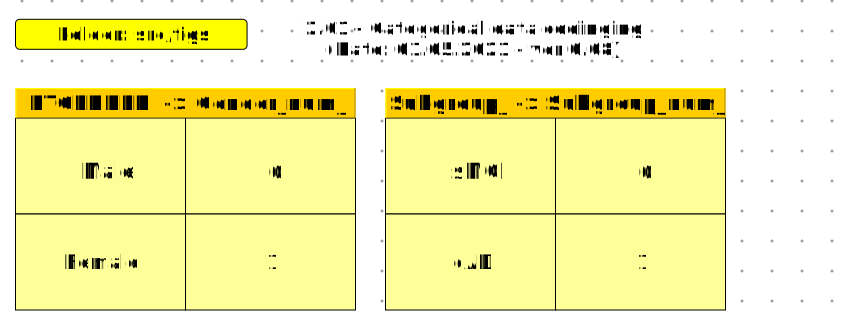

In [22]:
SVG(filename='figs/2.01_preprocessing_categorical_2_num.svg')

---

## REMOVE `SUBGROUP_`, `Subgroup_num_` and `Usage_` COLUMNS FROM THE TRAIN & TEST SETS

In [23]:
print('From:')
for name, X in X_sets:
    print(f'\t{name}')
    
    for feat in ['Subgroup_', 'Subgroup_num_', 'Usage_', 'PTGENDER']:
        if feat in X.columns: X.drop(columns=feat,inplace=True); print(f'\t\tRemoved: {feat}')

From:
	X train set
		Removed: Subgroup_
		Removed: Subgroup_num_
		Removed: Usage_
		Removed: PTGENDER
	X test set
		Removed: Subgroup_
		Removed: Subgroup_num_
		Removed: Usage_
		Removed: PTGENDER


In [24]:
print('Column names in:\n')
for name, X in X_sets:
    print(f'- {name}:\n  {X.columns.to_list()}\n')

Column names in:

- X train set:
  ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'LRHHC_n_long', 'LRLV_n_long', 'FAQ', 'Gender_num_']

- X test set:
  ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'LRHHC_n_long', 'LRLV_n_long', 'FAQ', 'Gender_num_']



#### BASIC STATISTISC OF FEATURES IN TRAIN AND TEST SETS

In [25]:
if VERBOSE:
    print('Basic statistics for features in both sets:')
    for name, X in X_sets:
        print(f'\n{name} (Subjects {X.shape[0]}):')
        display(minfo.df_stats_info(X, precision=2))

Basic statistics for features in both sets:

X train set (Subjects 540):


max.    mean  min.    std  val_range  NaN_Nr
AGE                91.40   73.56  55.2   7.25      36.20       0
RAVLT_immediate    67.00   33.09  11.0  10.35      56.00       0
AVDEL30MIN_neuro   15.00    3.53   0.0   3.73      15.00       0
AVDELTOT_neuro     15.00   10.33   0.0   3.49      15.00       0
TRAASCOR_neuro    150.00   41.99  13.0  18.35     137.00       0
TRABSCOR_neuro    300.00  121.34  33.0  67.20     267.00       0
CATANIMSC_neuro    35.00   16.85   5.0   5.12      30.00       0
GDTOTAL_gds         6.00    1.69   0.0   1.45       6.00       0
LRHHC_n_long        0.01    0.00   0.0   0.00       0.00       0
LRLV_n_long         0.08    0.03   0.0   0.01       0.07       0
FAQ                22.00    3.36   0.0   4.07      22.00       0
Gender_num_         1.00    0.39   0.0   0.49       1.00       0


X test set (Subjects 140):


max.    mean   min.    std  val_range  NaN_Nr
AGE                88.40   73.50  55.00   7.35      33.40       0
RAVLT_immediate    65.00   33.97  20.00   8.73      45.00       0
AVDEL30MIN_neuro   14.00    3.59   0.00   3.42      14.00       0
AVDELTOT_neuro     15.00   10.68   1.00   3.41      14.00       0
TRAASCOR_neuro    150.00   41.10  16.00  20.35     134.00       0
TRABSCOR_neuro    300.00  116.42  38.00  65.70     262.00       0
CATANIMSC_neuro    30.00   17.04   6.00   4.82      24.00       0
GDTOTAL_gds         5.00    1.64   0.00   1.25       5.00       0
LRHHC_n_long        0.01    0.00   0.00   0.00       0.00       0
LRLV_n_long         0.08    0.03   0.01   0.01       0.07       0
FAQ                21.00    3.38   0.00   4.42      21.00       0
Gender_num_         1.00    0.41   0.00   0.49       1.00       0

---

# GRID SEARCH (PERFORM  OR LOAD)

In [26]:
# Run gridsearch (if grid_search=1) and save the model to a file
# Load the best model from the file (if grid_search = 0)
grid_search = 1

# A filename of the the whole gridsearch structure
file_name_prefix_ext = FILE_NAME_WITH_GS_MODEL_TO_LOAD + '-GS-model.pkl'
file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext

# define a stratification sheme
skf = StratifiedKFold(n_splits=FOLDS, shuffle=False)

if grid_search:       
    print("Searching the best RF's parameters...")
    rfcl = RandomForestClassifier(random_state=RANDOM_STATE)

#     params = {"n_estimators": [40, 60, 70, 75, 80, 85, 90, 100, 120, 500, 1000, 10000],
#               "max_depth": [3, 4, 5, 6],
#               "max_features": [2, 3, 4, 5],
#               "min_samples_split": [1, 2, 3],
#               "min_samples_leaf": [1, 2, 3],
#               "bootstrap": [True, False],
#               "criterion": ["gini", 'entropy']}    
### RESULT:
                # Best score: 0.772

                # Best params:
                # 	bootstrap: True
                # 	criterion: entropy
                # 	max_depth: 5
                # 	max_features: 2
                # 	min_samples_leaf: 1
                # 	min_samples_split: 2
                # 	n_estimators: 40
                # Best params are stored in BEST_PARAMS variable!!!
    
    
    params = {"n_estimators": [30, 35, 40, 45, 50],
          "max_depth": [4, 5, 6],
          "max_features": [1, 2, 3],
          "min_samples_split": [1, 2, 3],
          "min_samples_leaf": [1, 2, 3],
          "bootstrap": [True, False],
          "criterion": ["gini", 'entropy']} 
   
    
    grid = GridSearchCV(estimator=rfcl, param_grid=params, verbose=1, refit='accuracy', cv=skf, n_jobs=32, 
                       scoring = ['accuracy', 'f1', 'precision', 'recall'])
    
    # fit the best estimator to the train data
    grid.fit(X_train, y_train)
    
    # save best estimator to the file
    joblib.dump(grid, file_name_prefix_path)     
    print(f'Saved GridSearch object to: {file_name_prefix_path}')
else:
    print(f"GridSearch parameters loaded from a file:\n\t\t{file_name_prefix_path}")
    grid = joblib.load(file_name_prefix_path)     

    
clf = grid.best_estimator_

print()
print(f'Best score: {grid.best_score_:.3f}\n')

print(f'Best params:')
for k,v in grid.best_params_.items():
    print(f'\t{k}: {v}')
    
# save best params to a global variable
print('Best params are stored in BEST_PARAMS variable!!!')
BEST_PARAMS = grid.best_params_


#print(grid.cv_results_)
# for k in metrics.SCORERS.keys():
#     print(k)

Searching the best RF's parameters...
Fitting 10 folds for each of 1620 candidates, totalling 16200 fits
Saved GridSearch object to: /home/marek/Dropbox/p1ext4_P/no_work/MCI/MCI-subgroups/results/20210420/3.32_RF-bl-GS-model.pkl

Best score: 0.772

Best params:
	bootstrap: True
	criterion: entropy
	max_depth: 5
	max_features: 2
	min_samples_leaf: 1
	min_samples_split: 2
	n_estimators: 40
Best params are stored in BEST_PARAMS variable!!!


---

# A PIPELINE WITH ESTABLISHED RF PARAMETERS (AFTER GRID SEARCH) 

---

In [27]:
# skf = StratifiedShuffleSplit(n_splits=FOLDS, random_state=42)
# for k, (train_index, validation_index) in enumerate(skf.split(X_train, X_train[['Subgroup_num_','Gender_num_']])):
#     #print("TRAIN:", train_index.shape, "VAL:", test_index.shape)
#     X_trainCV, X_validCV = X_train.iloc[train_index,:], X_train.iloc[validation_index,:]
#     y_trainCV, y_validCV = y_train.iloc[train_index], y_train.iloc[validation_index]
#     s = f'SSS_CV{FOLDS}_F{k:0>2}_'
#     print(s)
#     ss = s.split('_')
#     print(int(ss[2][1:]))
#     print(len(train_index),len(validation_index), len(train_index)+len(validation_index))
#     print(validation_index)

## PREPARE `CV` FOLDS FOR FURTHER USE

**Remark** Those folds should be prepared before GS! (For the future)

In [28]:
skf = StratifiedKFold(n_splits=FOLDS, shuffle=False)
SPLITS = []

for k, (train_index, validation_index) in enumerate(skf.split(X_train,y_train)):
#     X_trainCV, X_validCV = X_train.iloc[train_index,:], X_train.iloc[validation_index,:]
#     y_trainCV, y_validCV = y_train.iloc[train_index], y_train.iloc[validation_index]
    SPLITS.append((train_index, validation_index))

---

## CV10 SCORES (F1, ACCURACY, REACALL, PRECISION)

In [29]:
X_train.shape

(540, 12)

In [30]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
scores_cv = cross_validate(clf, X_train, y_train, cv=SPLITS, scoring=['accuracy', 'f1', 'recall', 'precision'])

scores_cv_df = pd.DataFrame(scores_cv)
scores_cv_df = scores_cv_df[['test_accuracy', 'test_f1', 'test_recall', 'test_precision']]
scores_cv_df.rename(columns = {'test_accuracy': 'acc', 'test_f1':'f1',
                               'test_recall':'recall', 'test_precision':'prec'}, inplace=True)
display(scores_cv_df)

acc        f1    recall      prec
0  0.722222  0.727273  0.800000  0.666667
1  0.722222  0.736842  0.840000  0.656250
2  0.777778  0.785714  0.880000  0.709677
3  0.796296  0.800000  0.880000  0.733333
4  0.888889  0.884615  0.920000  0.851852
5  0.814815  0.800000  0.769231  0.833333
6  0.740741  0.708333  0.653846  0.772727
7  0.740741  0.730769  0.730769  0.730769
8  0.833333  0.823529  0.807692  0.840000
9  0.685185  0.701754  0.769231  0.645161

### Mean score values for crossvalidation (k=10 folds):

In [31]:
prec = 2
score_all_folds_mean_df = pd.DataFrame.from_dict({'mean':scores_cv_df.mean().round(prec),
                                                  'std.':scores_cv_df.std().round(prec+1),
                                                  'min.':scores_cv_df.min().round(prec),
                                                  'max.':scores_cv_df.max().round(prec),
                                                  'range':scores_cv_df.values.ptp(axis=0).round(prec)})
display(score_all_folds_mean_df)

mean   std.  min.  max.  range
acc     0.77  0.062  0.69  0.89   0.20
f1      0.77  0.059  0.70  0.88   0.18
recall  0.81  0.079  0.65  0.92   0.27
prec    0.74  0.078  0.65  0.85   0.21

----

In [32]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)


feat_import_CV = pd.DataFrame(index=X_train.columns, columns=list(range(FOLDS)))
conf_matrix_CV = np.zeros((FOLDS, 2 ,2))
valid_set_len_CV = np.ones(10)  # to calculate mean validation test lenght
bl_CV_pred_all = pd.DataFrame()


for k, (train_index, validation_index) in enumerate(SPLITS):
    X_trainCV, X_validCV = X_train.iloc[train_index,:], X_train.iloc[validation_index,:]
    y_trainCV, y_validCV = y_train.iloc[train_index], y_train.iloc[validation_index]
      
    # MODEL    
    # fit
    clf.fit(X_trainCV, y_trainCV)
    # predict
    y_predCV= clf.predict(X_validCV).reshape(-1,)
    
    # METRICS
    # confusion matrix for all folds
    conf_matrix_CV[k, :, :]  = metrics.confusion_matrix(y_validCV, y_predCV)    
    # feature importance for all folds
    feat_import_CV[k] = clf.feature_importances_
    
    # CONFUSION MATRIX coefficients
    X_validCV_extended = mrfbl.confusion_matrix_coefficients_TPTNFPFN(X_validCV, y_validCV, y_predCV)
    
    # additional info about the current fold
    X_validCV_extended[f'CV{FOLDS}F_'] = k
    X_validCV_extended[f'CV{FOLDS}_Usage_'] = 'valid' 
    
    # df to agregate confusion-matrix-coefficients from all folds
    bl_CV_pred_all = pd.concat([bl_CV_pred_all, X_validCV_extended], axis=0)     
    
    # df with MISCLASSIFIED subjects in the current fold (k)
    err = X_validCV_extended.loc[(X_validCV_extended.y_true_ != X_validCV_extended.y_pred_)]
    print(f'fold: {k}, errors: {err.shape[0]}/{y_validCV.shape[0]}  ({err.shape[0]/y_validCV.shape[0]*100 :.1f}%)')
       
    # set current validation test set length
    valid_set_len_CV[k] = len(y_validCV)

fold: 0, errors: 15/54  (27.8%)
fold: 1, errors: 15/54  (27.8%)
fold: 2, errors: 12/54  (22.2%)
fold: 3, errors: 11/54  (20.4%)
fold: 4, errors: 6/54  (11.1%)
fold: 5, errors: 10/54  (18.5%)
fold: 6, errors: 14/54  (25.9%)
fold: 7, errors: 14/54  (25.9%)
fold: 8, errors: 9/54  (16.7%)
fold: 9, errors: 17/54  (31.5%)


In [33]:
#df_predictions_all.tail(3)

#### LINK PREDICTION TABLE WITH OTHER SUBJECT FEATURES

The predictions and all other subject features are stored in a `csv` file.

In [34]:
cols2 =[f'CV{FOLDS}F_',  f'CV{FOLDS}_Usage_'] 
filename = FILE_NAME_PREFIX + f'-CV{FOLDS}-predictions.csv'

bl_CV_pred_full = mrfbl.link_prediction_results_with_other_subject_features(bl_loaded, bl_CV_pred_all, cols2,
                                                                            filename, save=True, results_dir=RESULTS_DIR)


Subjects in the predictions table: 540

Predictions have been saved to a file:
		/home/marek/Dropbox/p1ext4_P/no_work/MCI/MCI-subgroups/results/20210420/3.32_RF-bl-CV10-predictions.csv


#### INTERACTIVE FOLDS INVESTIGATION (OPTIONAL)

In [35]:
if VERBOSE:
    cols = ['RID',  'y_true_', 'y_pred_', 'CM_pred_', f'CV{FOLDS}F_']
    minfo.iterate_patient_GUI(bl_CV_pred_full[cols], column=f'CV{FOLDS}F_')

---

# MODEL ANALYSIS & VISUALIZATION

---

## FEATURE IMPORTANCE (AVERAGE OUT OF 10 FOLDS)

In [36]:
feat_import_CV.reset_index(inplace=True)
feat_import_CV = feat_import_CV.rename({'index': 'feature'}, axis='columns')

#### FATURE IMPORTANCE IN EACH FOLD

In [37]:
if VERBOSE:
    display(feat_import_CV)

feature         0         1         2         3         4  \
0                AGE  0.056265  0.063484  0.057983  0.063265  0.060554   
1    RAVLT_immediate  0.192500  0.175597  0.156741  0.151505  0.193439   
2   AVDEL30MIN_neuro  0.133543  0.126073  0.120455  0.150891  0.115763   
3     AVDELTOT_neuro  0.048712  0.060455  0.051562  0.051577  0.042750   
4     TRAASCOR_neuro  0.064063  0.067291  0.063172  0.074237  0.062571   
5     TRABSCOR_neuro  0.065516  0.063421  0.068846  0.062636  0.073895   
6    CATANIMSC_neuro  0.046449  0.045601  0.070588  0.049151  0.055751   
7        GDTOTAL_gds  0.023227  0.026980  0.022120  0.027303  0.022051   
8       LRHHC_n_long  0.130593  0.153114  0.135881  0.130216  0.134254   
9        LRLV_n_long  0.084504  0.070419  0.085087  0.069391  0.082495   
10               FAQ  0.139518  0.134217  0.152434  0.155672  0.143438   
11       Gender_num_  0.015108  0.013349  0.015131  0.014155  0.013040   

           5         6         7         8         9  
0   0.058073  0.059035  0.057766  0.057152  0.064016  
1   0.155873  0.172058  0.175240  0.180160  0.160127  
2   0.149299  0.149729  0.141189  0.149330  0.155341  
3   0.063784  0.069032  0.056397  0.058969  0.050853  
4   0.062627  0.056077  0.064716  0.059102  0.052686  
5   0.067173  0.065730  0.060769  0.055504  0.062721  
6   0.047643  0.058510  0.048969  0.037031  0.050432  
7   0.031477  0.021415  0.021338  0.022498  0.022237  
8   0.127931  0.131670  0.140219  0.142544  0.162348  
9   0.070653  0.068425  0.081580  0.081889  0.069082  
10  0.156046  0.135240  0.140242  0.138749  0.135196  
11  0.009420  0.013078  0.011575  0.017073  0.014962

#### AVERAGE FEATURE IMPORTANCE OVER 10 FOLDS

In [38]:
feat_import_CV_stats = pd.DataFrame.from_dict({'feature':feat_import_CV.feature, 'mean':feat_import_CV.mean(axis=1).round(2), 'std.':feat_import_CV.std(axis=1).round(2)})
feat_import_CV_stats.sort_values(by='mean',ascending=False)

feature  mean  std.
1    RAVLT_immediate  0.17  0.01
2   AVDEL30MIN_neuro  0.14  0.01
8       LRHHC_n_long  0.14  0.01
10               FAQ  0.14  0.01
9        LRLV_n_long  0.08  0.01
0                AGE  0.06  0.00
3     AVDELTOT_neuro  0.06  0.01
4     TRAASCOR_neuro  0.06  0.01
5     TRABSCOR_neuro  0.06  0.00
6    CATANIMSC_neuro  0.05  0.01
7        GDTOTAL_gds  0.02  0.00
11       Gender_num_  0.01  0.00

#### PLOT MEAN FEATURE IMPORTANCE FOR 10 FOLDS (OPTIONAL: SAVE, SIZE, ORIENTATION, ...)

Mean featue importacne plot saved to:
		/home/marek/Dropbox/p1ext4_P/no_work/MCI/MCI-subgroups/results/20210420/3.32_RF-bl-CV10-feat-importance-h.png



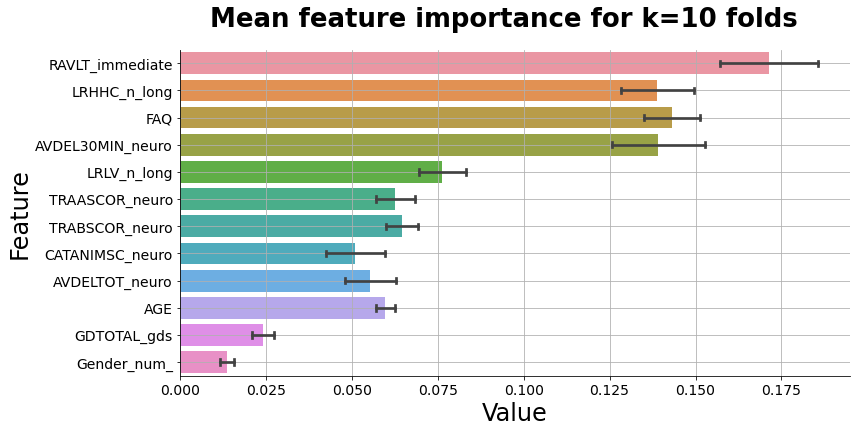

Mean featue importacne plot saved to:
		/home/marek/Dropbox/p1ext4_P/no_work/MCI/MCI-subgroups/results/20210420/3.32_RF-bl-CV10-feat-importance-v.png



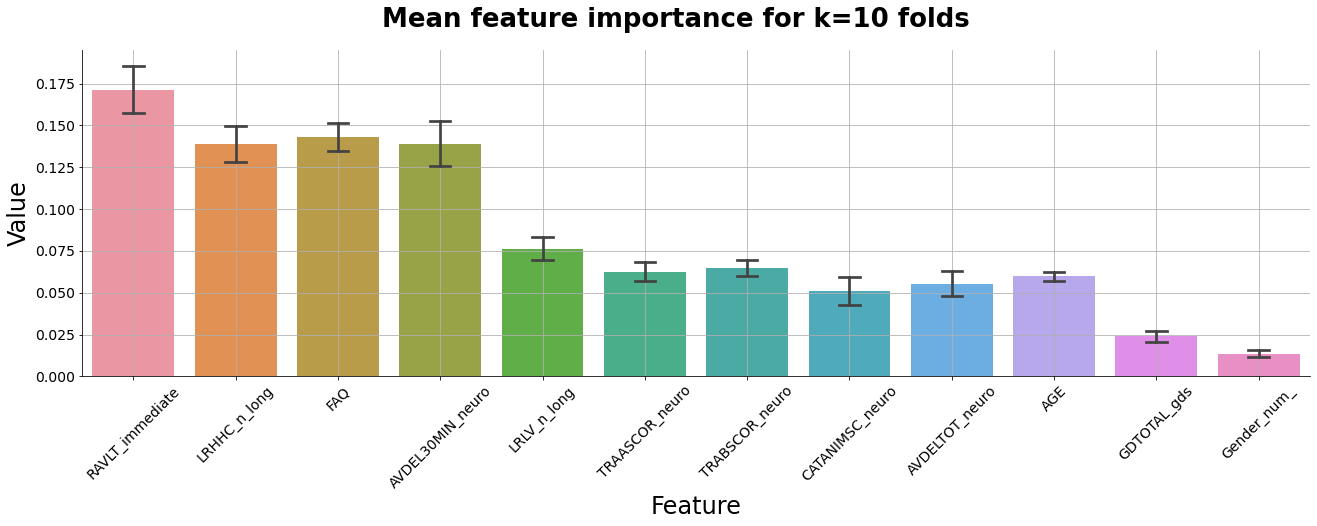

In [39]:
mrfbl.plot_mean_feature_importnce_cv(feat_import_CV, file_name_prefix=FILE_NAME_PREFIX,
                                     orientation='h',folds=FOLDS,figsize=(12,6), results_dir=RESULTS_DIR)

mrfbl.plot_mean_feature_importnce_cv(feat_import_CV, file_name_prefix=FILE_NAME_PREFIX,
                                     orientation='v', folds=FOLDS, figsize=(22,6), results_dir=RESULTS_DIR)

---

## CONFUSION MATRIX

#### NUMBER OF SUBJECTS IN EACH FOLD

In [40]:
if VERBOSE:
    print(f'Subjects in each fold:\n\t{valid_set_len_CV}\n')
    print(f'Meand fold length: {valid_set_len_CV.mean()}')

Subjects in each fold:
	[54. 54. 54. 54. 54. 54. 54. 54. 54. 54.]

Meand fold length: 54.0


#### PLOT CONFUSION MATRIX

Confusion matrix saved to:

		/home/marek/Dropbox/p1ext4_P/no_work/MCI/MCI-subgroups/results/20210420/3.32_RF-bl-conf-matrix-CV10.png



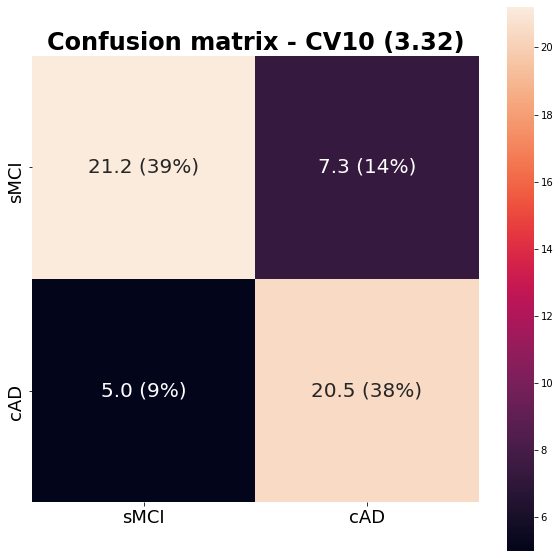

In [41]:
# mean of confusion matix over k=10 folds
conf_mat_mean = conf_matrix_CV.mean(axis=0)
# percantage values of confusion matix according to validatin set lenght
conf_mat_mean_prc = conf_mat_mean / valid_set_len_CV.mean() * 100

mrfbl.plot_confusion_matrix_CV(conf_mat_mean, conf_mat_mean_prc, folds=FOLDS, file_name_number=FILE_NAME_NUMBER,
                                file_name_prefix=FILE_NAME_PREFIX, result_dir=RESULTS_DIR, save=True)

---

## CORELATION (OPTIONAL)

In [42]:
# cor = X_train.corr().abs()
# cor2 = np.tril(cor2,  k=0)

# cor2 = pd.DataFrame(np.where(cor2>0.4, cor, 0), columns=X_train.columns)
# cor2.set_index(X_train.columns, inplace=True)

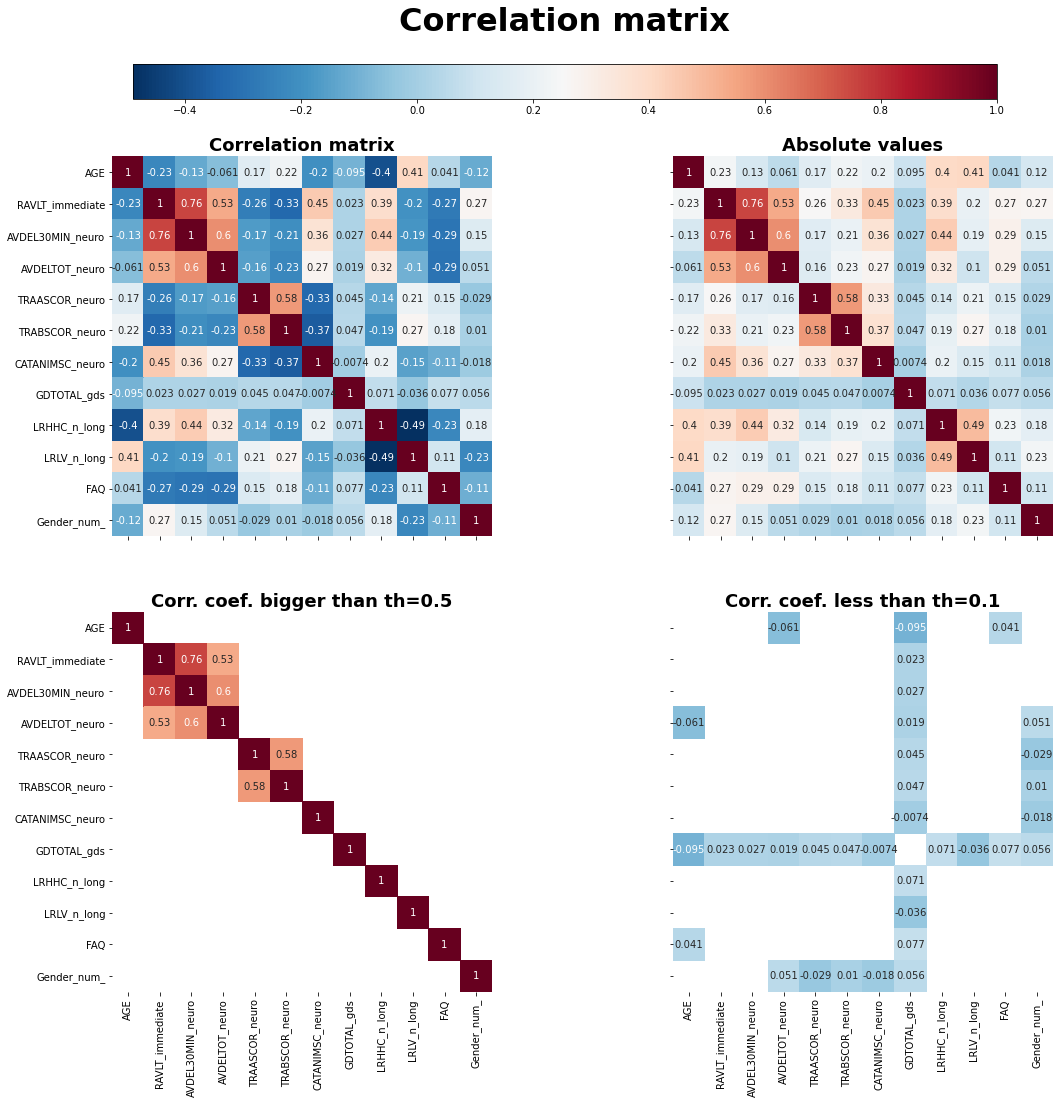

In [43]:
if VERBOSE:
    cor = X_train.corr()
    mn, mx = cor.values.min(), cor.values.max()
    cor_abs = X_train.corr().abs()    
    th1, th2 = 0.5, 0.1
    cor_th1 = cor[cor_abs>th1]
    cor_th2 = cor[cor_abs<th2]
    
    
    
    f,ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(20,16))
    sns.heatmap(cor, annot=True, cmap='RdBu_r', ax=ax[0,0], vmin=mn, vmax=mx, cbar=False)
    sns.heatmap(cor_abs, annot=True, cmap='RdBu_r', ax=ax[0,1], vmin=mn, vmax=mx, cbar=False)
    sns.heatmap(cor_th1, annot=True, cmap='RdBu_r', ax=ax[1,0], vmin=mn, vmax=mx, cbar=False)    
    sns.heatmap(cor_th2, annot=True, cmap='RdBu_r', ax=ax[1,1], vmin=mn, vmax=mx, cbar=False) 
    
    titles = ['Correlation matrix', 'Absolute values', f'Corr. coef. bigger than th={th1}', f'Corr. coef. less than th={th2}']
    for i,a in enumerate(ax.flat[:]):        
        a.set_aspect(aspect=1)
        a.set_title(titles[i], fontsize=18, fontweight='bold')
    
    
    cax = f.add_axes([0.2, 0.90, 0.6, 0.03])
    norm = plt.Normalize(mn, mx)
    sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
    sm.set_array([])
    f.colorbar(sm, cax=cax, orientation='horizontal')

    plt.suptitle('Correlation matrix', fontsize=32, fontweight='bold')
    plt.subplots_adjust(wspace=0.01, top=0.85)
    #plt.tight_layout(rect=[0,0,1,0.85])

---

## VISUALIZATION (OPTIONAL)

In [44]:
if VERBOSE:
    #https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c
    # Extract single tree
    estimator = clf.estimators_[4]

    from sklearn.tree import export_graphviz
    # Export as dot file
    export_graphviz(estimator, out_file='tree.dot', 
                    feature_names = X_train.columns,
                    class_names = ['sMCi','cAD'],
                    rounded = True, proportion = False, 
                    precision = 2, filled = True)

    # Convert to png using system command (requires Graphviz)
    from subprocess import call
    filename1 = FILE_NAME_PREFIX + '-tree.png'
    filename2 = FILE_NAME_PREFIX + '-tree.pdf'

    filepath1 = RESULTS_DIR/filename1
    filepath2 = RESULTS_DIR/filename2

    call(['dot', '-Tpng', 'tree.dot', '-o', filepath1, '-Gdpi=300'])
    call(['dot', '-Tpdf', 'tree.dot', '-o', filepath2, '-Gdpi=600'])

    # Display in jupyter notebook
    display(Image(filename=filepath1))

#### REMOVE TEMPORARY `tree.png` and `tree.dot` FILES FROM THE CURRENT FOLDER

In [45]:
if 1:
    [f.unlink() for f in list(Path('.').glob("tree.*"))]

---

# TEST SET

---

#### TEST SETS VISUAL INSPECTIONS (OPTIONAL)

In [46]:
if VERBOSE:    
    tmp_df = pd.DataFrame.from_dict({'X_test_mean':X_test.mean().round(2), 'X_test_std':X_test.std().round(2)})
    
    print('"Original" Test set ')
    display(X_test.head())
    print('\nMean and std comparison')
    display(tmp_df)

"Original" Test set 


AGE  RAVLT_immediate  AVDEL30MIN_neuro  AVDELTOT_neuro  TRAASCOR_neuro  \
6    80.4             30.0               1.0             7.0            49.0   
82   77.3             29.0               0.0            11.0           122.0   
184  77.5             35.0               1.0            10.0            27.0   
359  71.1             24.0               0.0             2.0            50.0   
384  83.6             30.0               2.0             9.0            22.0   

     TRABSCOR_neuro  CATANIMSC_neuro  GDTOTAL_gds  LRHHC_n_long  LRLV_n_long  \
6             168.0             13.0          0.0      0.003638     0.026915   
82            151.0             17.0          2.0      0.003343     0.076179   
184            69.0             24.0          2.0      0.003149     0.023619   
359            85.0             13.0          2.0      0.003729     0.021541   
384            76.0             18.0          0.0      0.003700     0.019198   

     FAQ  Gender_num_  
6    0.0            1  
82   7.0            0  
184  0.0            1  
359  3.0            1  
384  0.0            1


Mean and std comparison


X_test_mean  X_test_std
AGE                     73.50        7.35
RAVLT_immediate         33.97        8.73
AVDEL30MIN_neuro         3.59        3.42
AVDELTOT_neuro          10.68        3.41
TRAASCOR_neuro          41.10       20.35
TRABSCOR_neuro         116.42       65.70
CATANIMSC_neuro         17.04        4.82
GDTOTAL_gds              1.64        1.25
LRHHC_n_long             0.00        0.00
LRLV_n_long              0.03        0.01
FAQ                      3.38        4.42
Gender_num_              0.41        0.49

---

## TRAIN THE RF CLASSIFIER AND PREDICT SUBGROPUS WITH THE USE OF UNSEEN TEST SET

In [47]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)

#compare two ways of accuracy calucation
if VERBOSE:
    print(metrics.accuracy_score(y_test, y_test_pred).round(3))
    print(clf.score(X_test, y_test).round(3))

0.743
0.743


## TEST SET SCORES (F1, ACCURACY, RECALL, PRECISION)

In [48]:
# metrics
f1 = metrics.f1_score(y_test, y_test_pred)
acc = metrics.accuracy_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test, y_test_pred)
prec = metrics.precision_score(y_test, y_test_pred)

print(f'F1: {f1:.3f}')
print(f'ACC: {acc:.3f}')
print(f'RECALL: {recall:.3f}')
print(f'PREC: {prec:.3f}')

F1: 0.727
ACC: 0.743
RECALL: 0.738
PREC: 0.716


## CONUSIOM MATRIX

#### PREDICTIONS

In [49]:
bl_test_pred = mrfbl.confusion_matrix_coefficients_TPTNFPFN(X_test, y_test, y_test_pred)

cols2= []
filename = FILE_NAME_PREFIX + f'-TEST-predictions.csv'
bl_test_pred_full = mrfbl.link_prediction_results_with_other_subject_features(bl_loaded, bl_test_pred, cols2, filename,
                                                                              save=True, results_dir=RESULTS_DIR)


Subjects in the predictions table: 140

Predictions have been saved to a file:
		/home/marek/Dropbox/p1ext4_P/no_work/MCI/MCI-subgroups/results/20210420/3.32_RF-bl-TEST-predictions.csv


In [50]:
conf_matrix_test  = metrics.confusion_matrix(y_test, y_test_pred)    

# mean of test confusion matix
conf_mat_mean = conf_matrix_test.mean(axis=0)
# percantage values of confusion matix according to validatin set lenght
conf_matrix_test_prc = conf_matrix_test / y_test.shape[0] * 100


mrfbl.plot_confusion_matrix_TEST(conf_matrix_test, conf_matrix_test_prc, file_name_number=FILE_NAME_NUMBER, file_name_prefix=FILE_NAME_PREFIX,
                                 save=True, results_dir=RESULTS_DIR)

## FEATURE IMPORTANCE

In [51]:
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
print(f'Feature importance for the train set:\n\n{feature_imp.to_string()}')

Feature importance for the train set:

RAVLT_immediate     0.168986
AVDEL30MIN_neuro    0.145632
FAQ                 0.135626
LRHHC_n_long        0.129461
LRLV_n_long         0.081685
TRABSCOR_neuro      0.076102
AGE                 0.059506
TRAASCOR_neuro      0.059089
CATANIMSC_neuro     0.055979
AVDELTOT_neuro      0.054506
GDTOTAL_gds         0.022918
Gender_num_         0.010510


Mean featue importacne plot saved to:
		/home/marek/Dropbox/p1ext4_P/no_work/MCI/MCI-subgroups/results/20210420/3.32_RF-bl-TEST-feat-importance-h.png



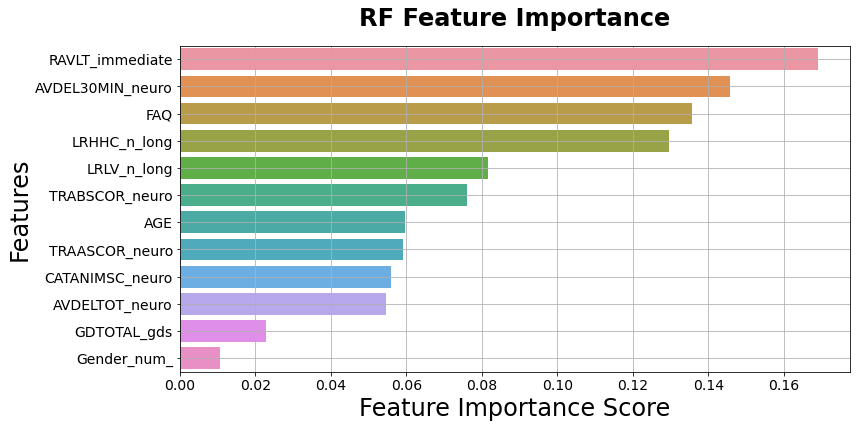

Mean featue importacne plot saved to:
		/home/marek/Dropbox/p1ext4_P/no_work/MCI/MCI-subgroups/results/20210420/3.32_RF-bl-TEST-feat-importance-v.png



In [52]:
mrfbl.plot_single_feature_importnce(feature_imp,
                                    FILE_NAME_PREFIX, orientation='h', figsize=(12,6), results_dir = RESULTS_DIR)

mrfbl.plot_single_feature_importnce(feature_imp,
                                    FILE_NAME_PREFIX, orientation='v', figsize=(22,6), results_dir = RESULTS_DIR)

---

# FEATURE PERMUTATION WITH `eli5` 
([www](https://eli5.readthedocs.io/en/latest/overview.html))

In [53]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, max_features=2,
                       n_estimators=40, random_state=42)

#### TRAIN SET

In [54]:
# perm = PermutationImportance(clf, random_state=RANDOM_STATE).fit(X_train, y_train)
# eli5.show_weights(perm, feature_names = X_train.columns.tolist())

## TEST SET

In [55]:
perm = PermutationImportance(clf, random_state=RANDOM_STATE).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(),)

---

# PARTIAL DEPENDENCE PLOTS

#### 1D PDPs

In [56]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, max_features=2,
                       n_estimators=40, random_state=42)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


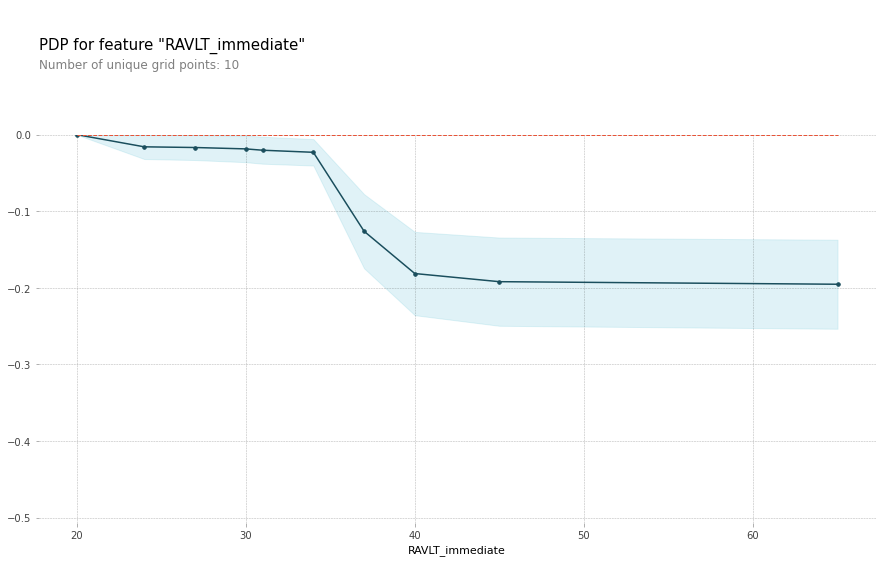

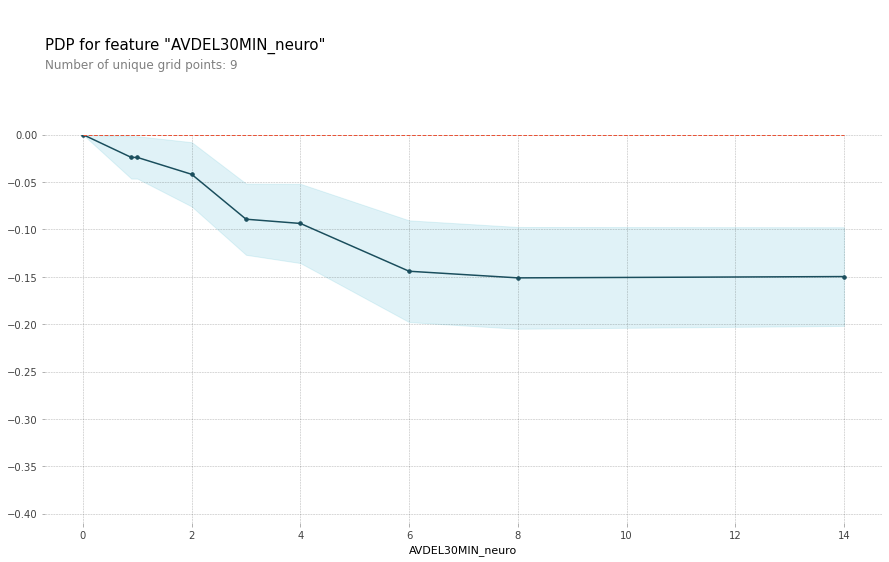

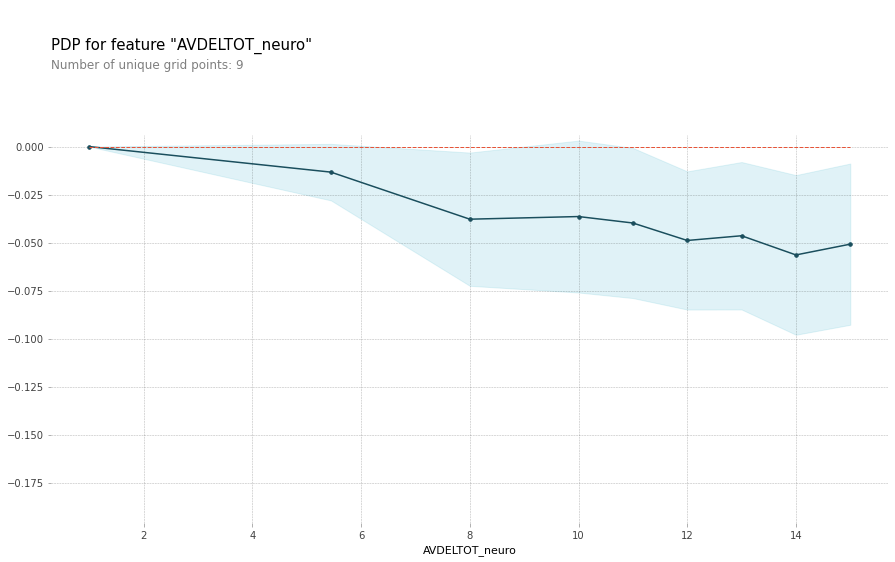

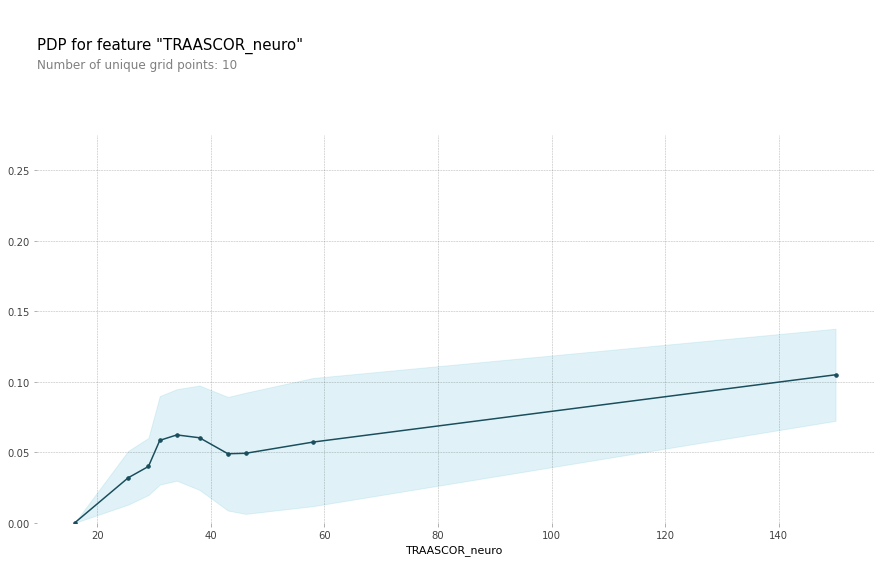

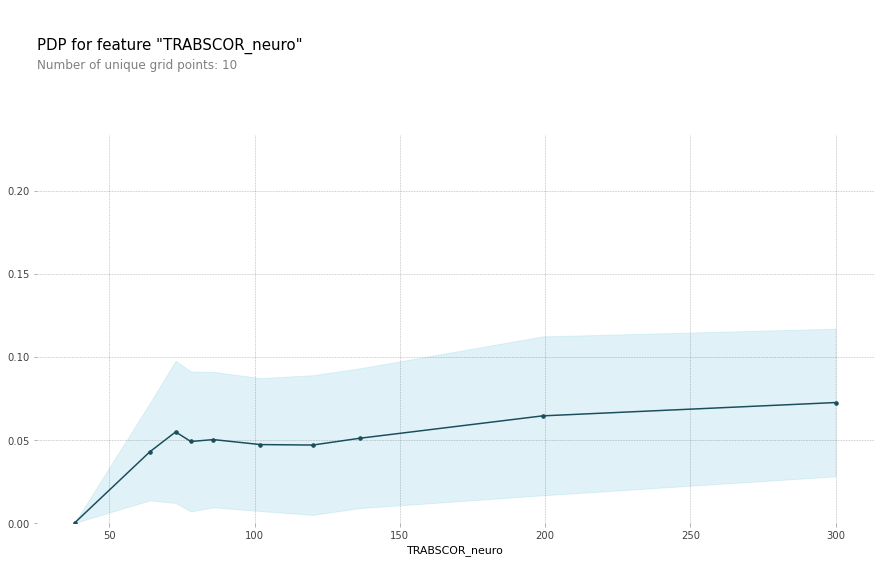

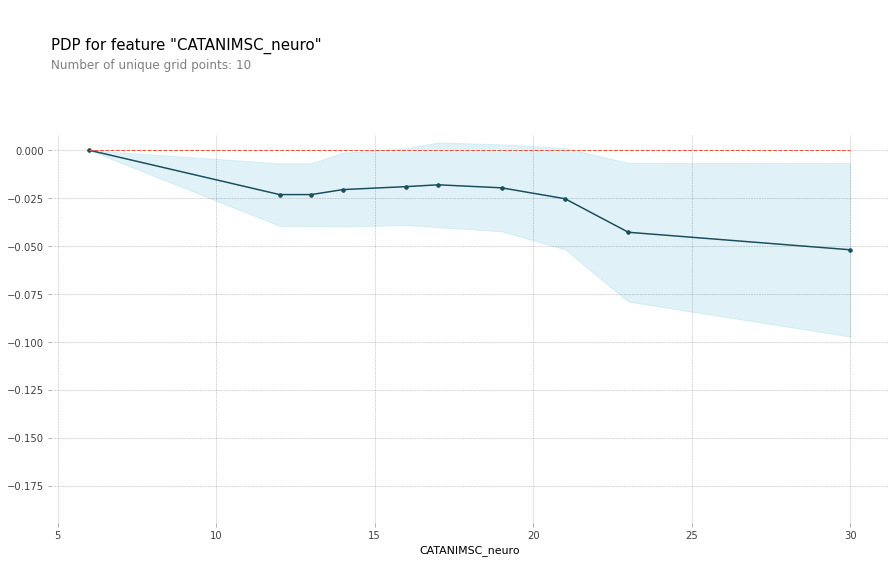

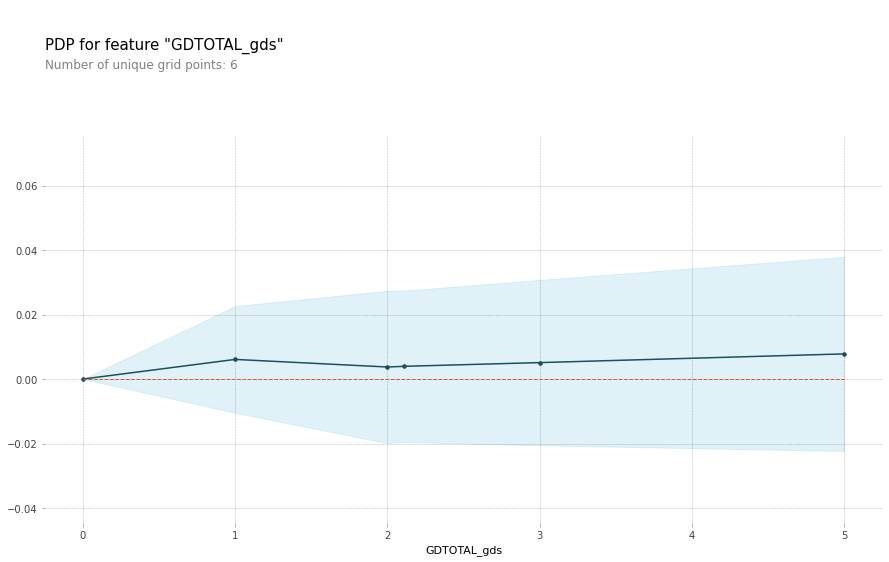

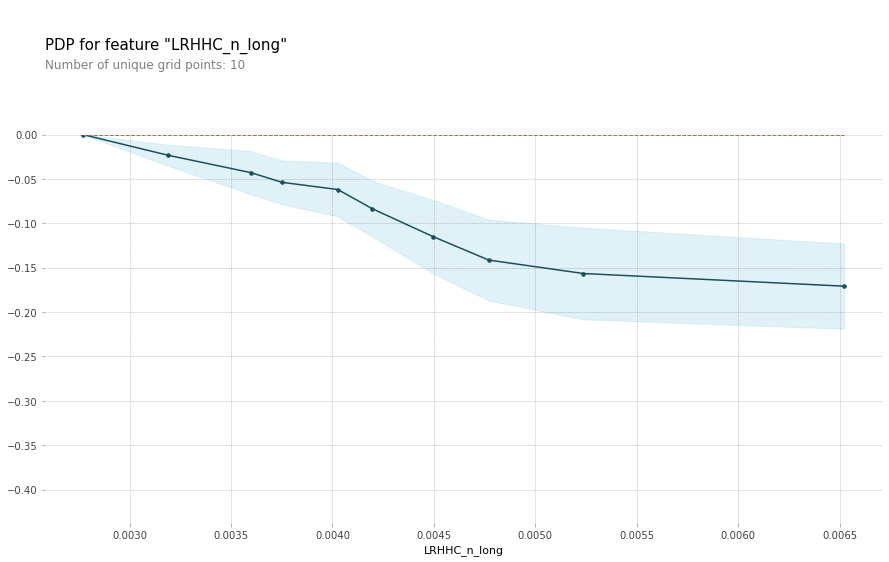

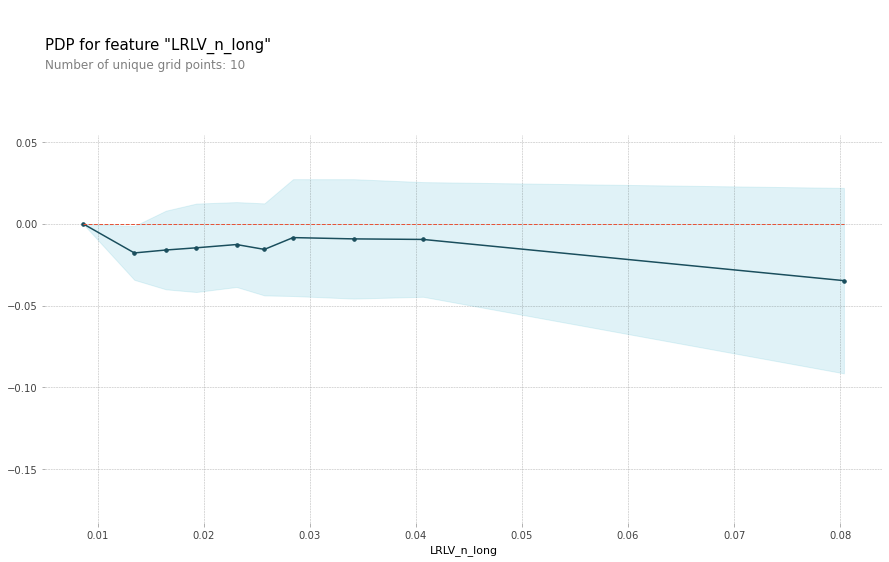

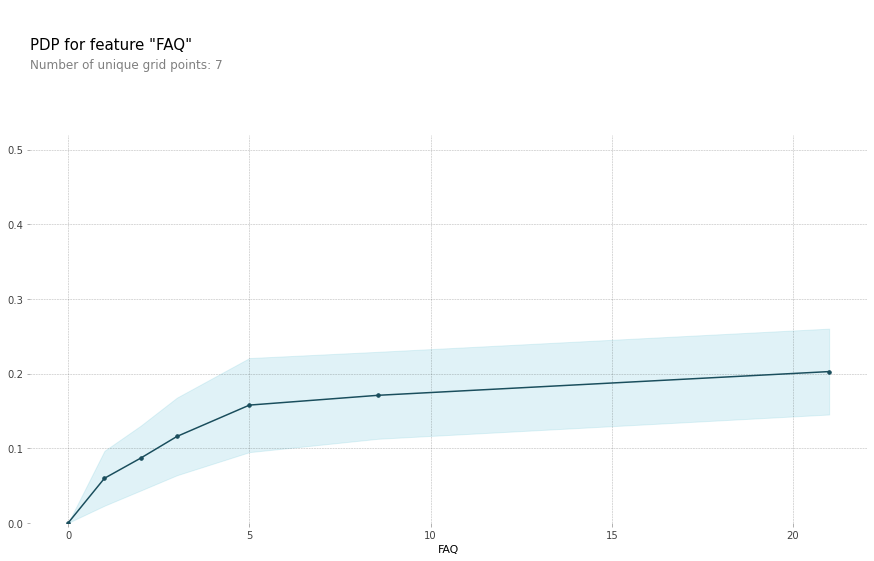

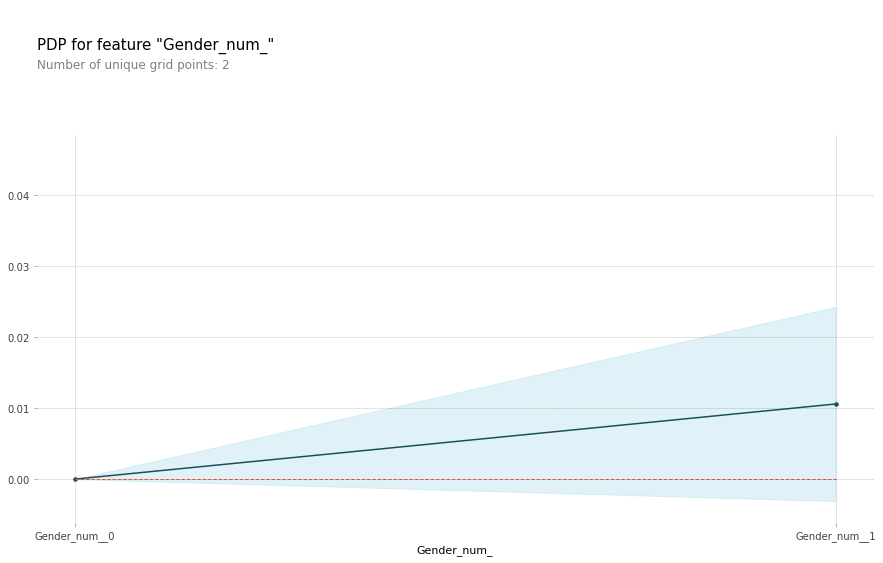

In [57]:
for feature in X_test.columns:
    pdp_goals = pdp.pdp_isolate(model=clf, dataset=X_test, model_features=X_test.columns.tolist(),
                                feature=feature)    
    pdp.pdp_plot(pdp_goals, feature)

    file_name_prefix_ext = f'{FILE_NAME_PREFIX}-pdp-TEST-{feature}.png'
    file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext
    plt.savefig(file_name_prefix_path)

    plt.show()

#### 2D PDPs

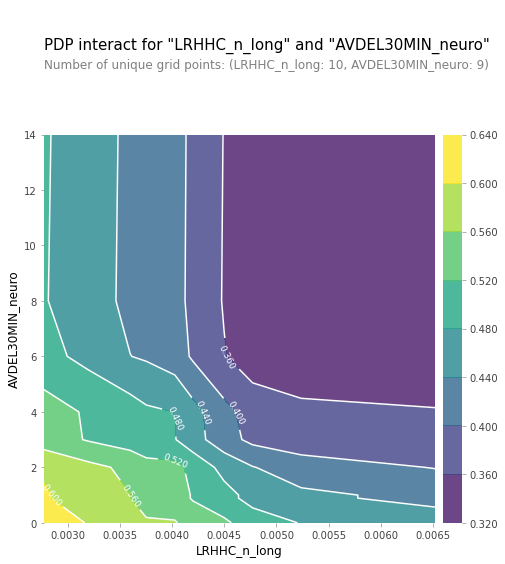

In [58]:
feat = ['LRHHC_n_long', 'AVDEL30MIN_neuro']
interact  =  pdp.pdp_interact(model=clf, dataset=X_test, model_features=X_test.columns.tolist(), features=feat)
pdp.pdp_interact_plot(pdp_interact_out=interact, feature_names=feat, plot_type='contour')
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


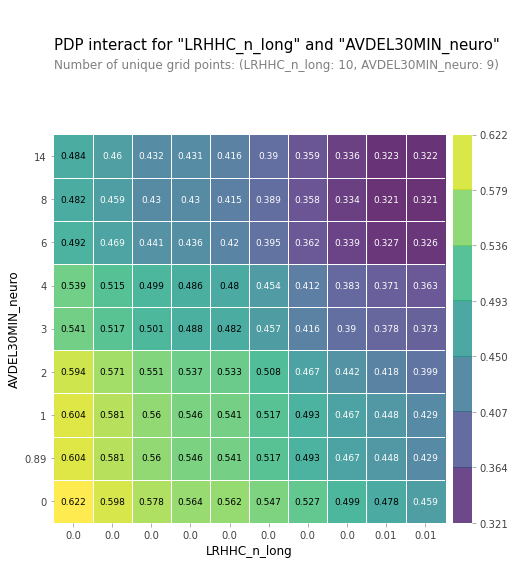

In [59]:
feat = ['LRHHC_n_long', 'AVDEL30MIN_neuro']
interact  =  pdp.pdp_interact(model=clf, dataset=X_test, model_features=X_test.columns.tolist(), features=feat)
pdp.pdp_interact_plot(pdp_interact_out=interact, feature_names=feat, plot_type='grid')
plt.show()

---

---

# PDP AND ICE PLOTS WITH SCIKIT-LEARN ([www](https://scikit-learn.org/stable/modules/partial_dependence.html))

In [60]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, max_features=2,
                       n_estimators=40, random_state=42)

In [61]:
print(FEATURES)

['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'LRHHC_n_long', 'LRLV_n_long', 'FAQ', 'Subgroup_', 'Subgroup_num_', 'Usage_', 'Gender_num_', 'PTGENDER']


#### PARTIAL DEPENDENCE PLOTS

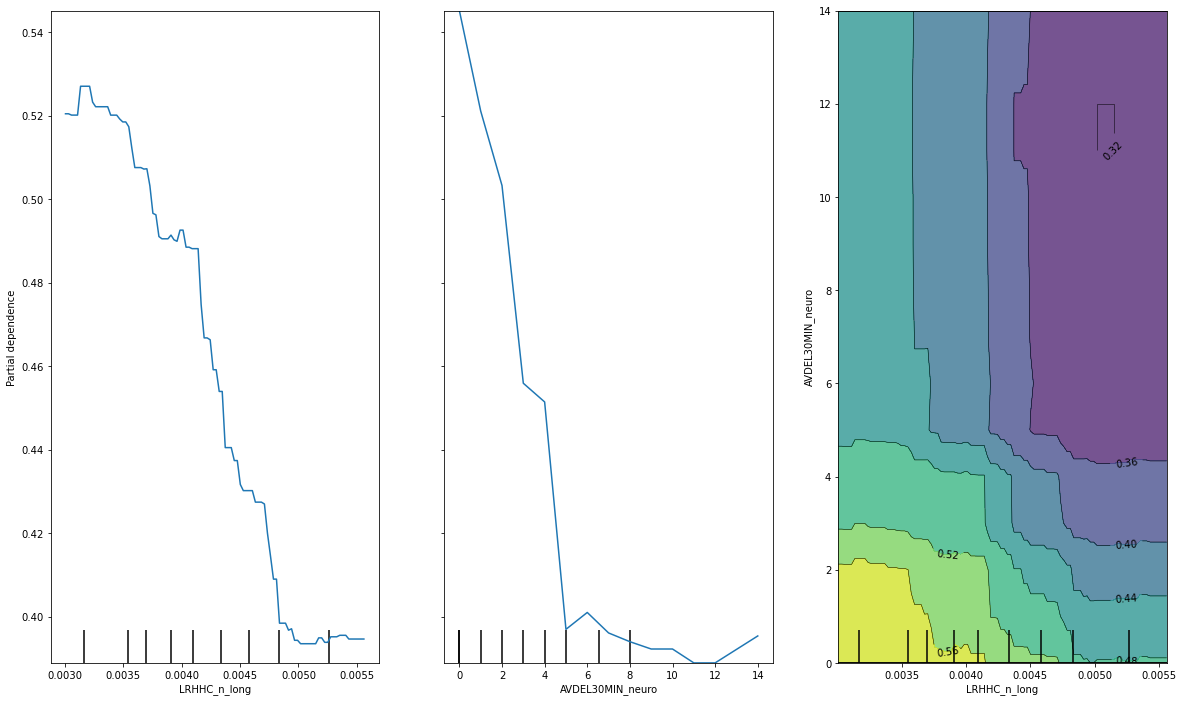

In [62]:
fig, ax = plt.subplots(figsize=(20,12))
plot_partial_dependence(clf, X_test, ['LRHHC_n_long','AVDEL30MIN_neuro', ('LRHHC_n_long', 'AVDEL30MIN_neuro')], ax=ax, n_jobs=32)

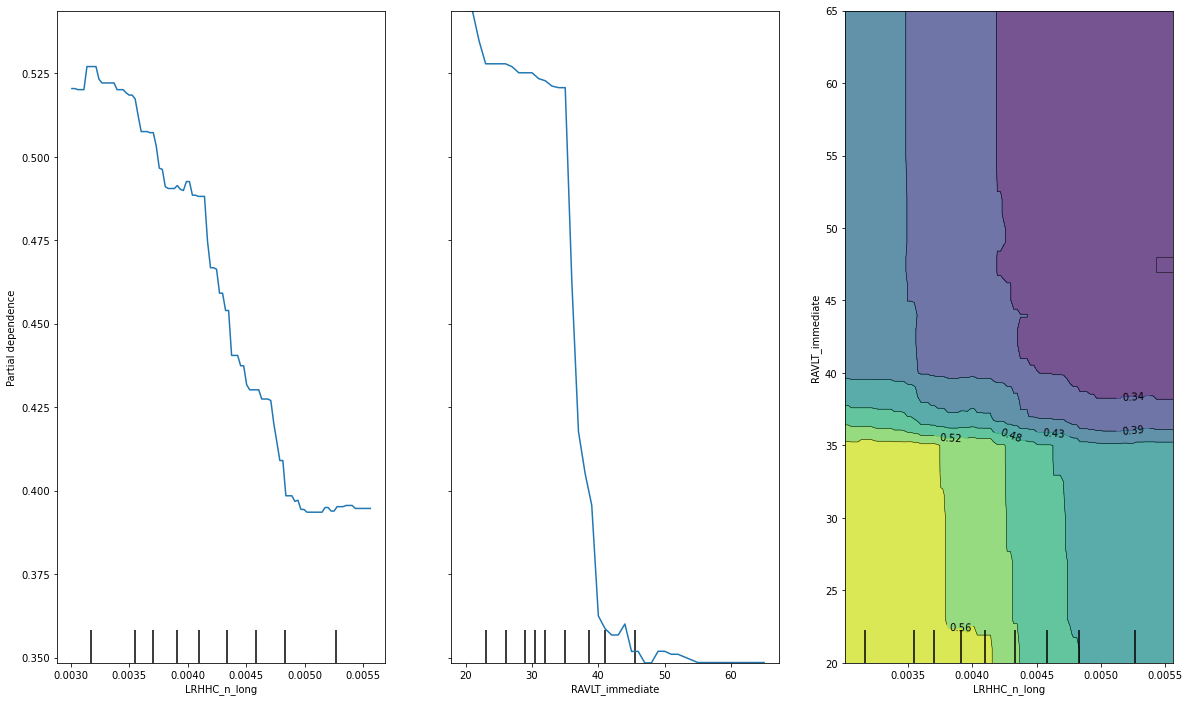

In [63]:
fig, ax = plt.subplots(figsize=(20,12))
plot_partial_dependence(clf, X_test, ['LRHHC_n_long','RAVLT_immediate', ('LRHHC_n_long', 'RAVLT_immediate')], ax=ax, n_jobs=32)

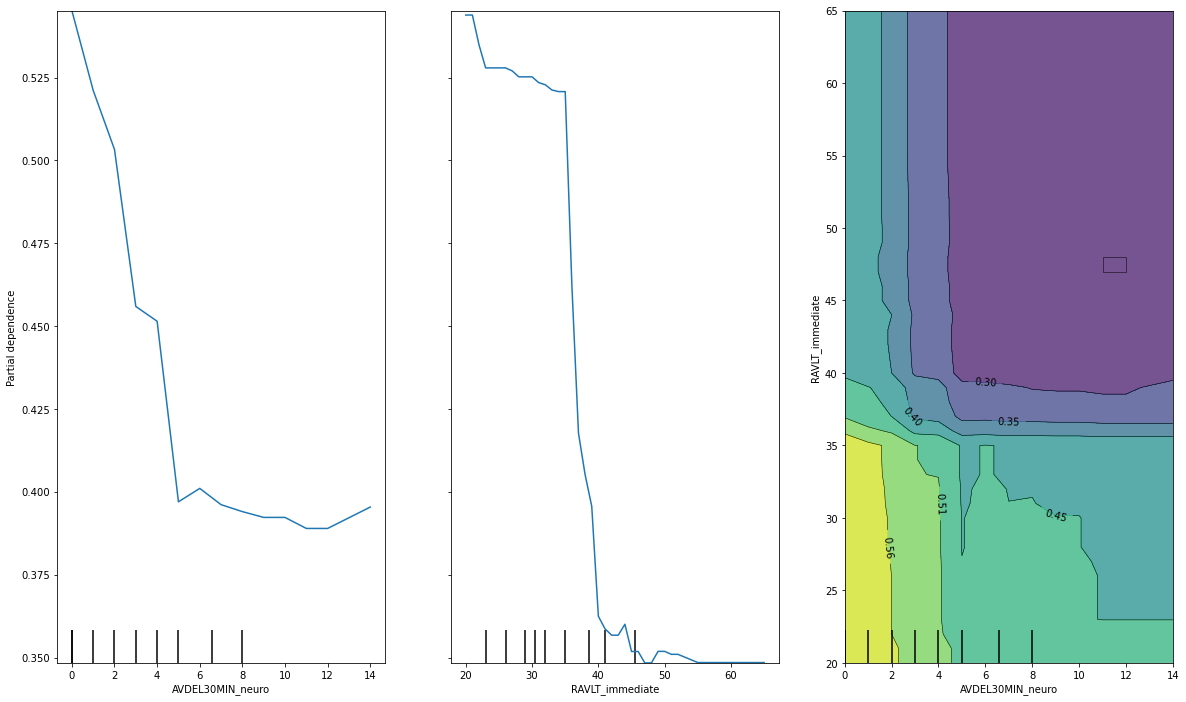

In [64]:
fig, ax = plt.subplots(figsize=(20,12))
plot_partial_dependence(clf, X_test, ['AVDEL30MIN_neuro','RAVLT_immediate', ('AVDEL30MIN_neuro', 'RAVLT_immediate')], ax=ax, n_jobs=32)

#### INDIVIDUAL CONDITIONAL EXPECTATION (ICE) PLOTS - TRAIN SET

In [65]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, max_features=2,
                       n_estimators=40, random_state=42)

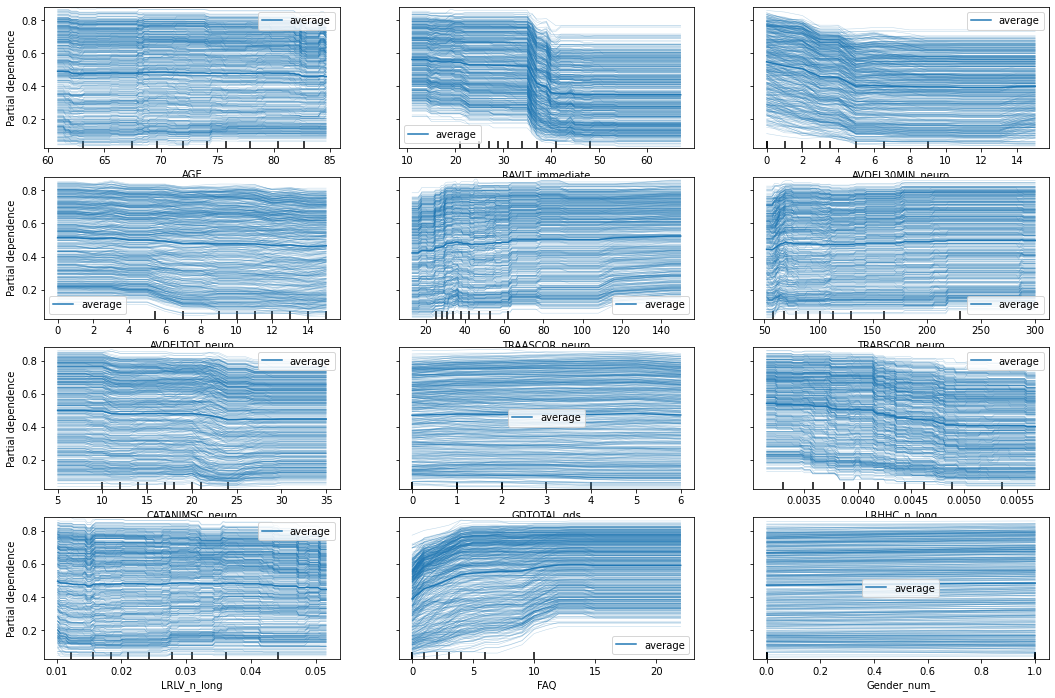

In [66]:
fig,ax = plt.subplots(figsize=(18,12),)
_=plot_partial_dependence(clf, X_train, features=X_train.columns, kind='both', ax=ax)

#### INDIVIDUAL CONDITIONAL EXPECTATION (ICE) PLOTS - TEST SET

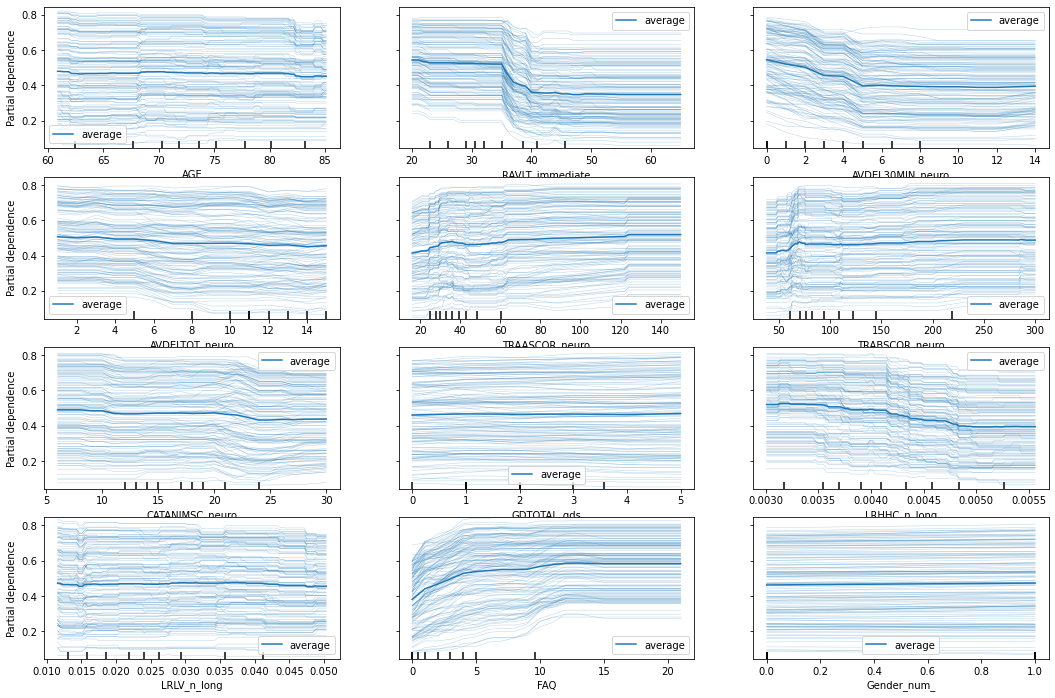

In [67]:
fig,ax = plt.subplots(figsize=(18,12))
_=plot_partial_dependence(clf, X_test, features=X_test.columns, kind='both', ax=ax)


---